## Phase - 4: Iterative Feature Reduction and Selection

**Motive:**
    
Before working on this phase, please practice "Activity 10" in the 'Neural networks using Tensorflow' crash course (see nn-tf tab). The key activity in this phase is to study the importance of the input features by iteratively removing them. In other words, you can first train various models with only one feature at a time to learn how predictive each feature is. Once the significance of each feature is known, you can remove the most unimportant feature (i.e., remove the column), retrain the model, and observe the accuracy. You can iteratively repeat the process removing more and more unimportant features. The overall objective is to identify non-informative input features and remove them from the dataset. Finally, you can compare your feature-reduced model with the original model with all input features and discuss the difference in accuracy. Here is an example report.

### Approach

This notebook contains two important steps performed as part of this phase-4

    Step - 1: Get model stats with single feature 
    Step - 2: Get model stats with Important features

#### Categorical Columns

'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login'

In [2]:
catg_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

#### Continuous Columns

In [3]:
cont_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [4]:
target_variable = 'label'

#### Data Load

In [6]:
import pandas as pd
df = pd.read_csv("../datasets/kddcup99_csv.csv")

#### Dataset size

In [7]:
df.shape

(494020, 42)

494020 records with 41 features and 1 target variable ("label") for prediction

In [8]:
df.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal


As seen above, there are various type of malware attacks which can be grouped as "abnormal" to make this problem as binary classification problem

##### Group all malware attacks as "abnormal"

In [9]:
attack_types = list(df['label'].unique())
attack_types.remove('normal') # remove normal from attack types as we only want malware attacks to convert as abnormal

In [10]:
df['label'] = df['label'].replace(attack_types, 'abnormal')
df.shape

(494020, 42)

In [11]:
# both these columns have all values as 0, hence not useful for our experiments
df.drop(columns=['is_host_login'], inplace=True)
df.drop(columns=['num_outbound_cmds'], inplace=True)
catg_cols.remove('is_host_login')
cont_cols.remove('num_outbound_cmds')

In [12]:
df['label'].value_counts()

abnormal    396743
normal       97277
Name: label, dtype: int64

In [13]:
# Transform Target Binary label to 0 and 1
df['label'] = df['label'].map({'normal': 1, 'abnormal': 0})
df['label'].value_counts()

0    396743
1     97277
Name: label, dtype: int64

In [14]:
for cat_col in catg_cols:
    df[cat_col] = df[cat_col].astype(str)

### Step - 1 Iterative Feature Reduction

In [92]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def _convert_categorical_to_one_hot_encoding(dataset, column_name):
    dummy_values = pd.get_dummies(dataset[column_name])
    #print("dummy_values", dummy_values.shape[1])
    for category in dummy_values.columns:
        dummy_value_name = f"{column_name}-{category}"
        dataset[dummy_value_name] = dummy_values[category]
    dataset.drop(column_name, axis=1, inplace=True)
    return dataset

def build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID):
    best_model_selected = Sequential()
    best_model_selected.add(Dense(4, input_dim = len(XTRAIN[0, :]), activation='relu'))
    best_model_selected.add(Dense(1, activation='sigmoid'))
    best_model_selected.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=[ 'accuracy'])
    best_model_selected_history = best_model_selected.fit(XTRAIN, YTRAIN, validation_data = (XVALID, YVALID), 
                                            batch_size=256, epochs =2, verbose = 1)
    return best_model_selected, best_model_selected_history
    
def get_model_accuracy_with_single_input(input_df, input_feature: str):
    
    if input_df.shape[1] != 2:
        raise Exception("Expected single feature input dataset")
    
    if input_feature in catg_cols:
        print(f"Single input feature is categorical and is : {input_feature}")
        input_df = _convert_categorical_to_one_hot_encoding(input_df, input_feature)
    else:
        print(f"Single input feature is continous and is {input_feature}")
        df_CONTCOLS_MIN = input_df[[input_feature]].min(axis=0)
        df_CONTCOLS_MAX = input_df[[input_feature]].max(axis=0)
        input_df[[input_feature]] = (input_df[[input_feature]] - df_CONTCOLS_MIN) / (df_CONTCOLS_MAX - df_CONTCOLS_MIN)
    
    if input_df.isna().values.any() is False:
        raise Exception("Cannot proceed with modeling with null values")
    
    print(input_df.shape)
    input_df = input_df.sample(frac=1).reset_index(drop=True)
    X_numpy = input_df.drop(columns=['label']).to_numpy()
    Y_numpy = input_df['label'].to_numpy()
    print(X_numpy.shape, Y_numpy.shape)
    
    # Split into training and validation, 20% validation set and 80% training 
    index_20percent = int(0.2 * len(input_df.to_numpy()[:, 0]))
    print(index_20percent)
    XVALID = X_numpy[:index_20percent]
    YVALID = Y_numpy[:index_20percent]
    XTRAIN = X_numpy[index_20percent:]
    YTRAIN = Y_numpy[index_20percent:]
    best_model_selected, best_model_selected_history = build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID)
    return best_model_selected, best_model_selected_history
    
def get_model_accuracy_with_one_or_more_multiple_inputs(input_df, input_features: str, continous_columns):
    
    # handle categorical if any
    for ip_feat in input_features:
        if ip_feat in catg_cols:
            input_df = _convert_categorical_to_one_hot_encoding(input_df, ip_feat)
    
    if len(continous_columns) > 0:
    
        df_CONTCOLS_MIN = input_df[continous_columns].min(axis=0)
        df_CONTCOLS_MAX = input_df[continous_columns].max(axis=0)
        input_df[continous_columns] = (input_df[continous_columns] - df_CONTCOLS_MIN) / (df_CONTCOLS_MAX - df_CONTCOLS_MIN)
    
    if input_df.isna().values.any() is False:
        raise Exception("Cannot proceed with modeling with null values")
    
    print(input_df.shape)
    input_df = input_df.sample(frac=1).reset_index(drop=True)
    X_numpy = input_df.drop(columns=['label']).to_numpy()
    Y_numpy = input_df['label'].to_numpy()
    print(X_numpy.shape, Y_numpy.shape)
    
    # Split into training and validation, 20% validation set and 80% training 
    index_20percent = int(0.2 * len(input_df.to_numpy()[:, 0]))
    print(index_20percent)
    XVALID = X_numpy[:index_20percent]
    YVALID = Y_numpy[:index_20percent]
    XTRAIN = X_numpy[index_20percent:]
    YTRAIN = Y_numpy[index_20percent:]
    best_model_selected, best_model_selected_history = build_best_model_from_previous_phase(XTRAIN, YTRAIN,XVALID,YVALID)
    return best_model_selected, best_model_selected_history

In [93]:
single_column_accuracy_stats = {}
all_cols = catg_cols + cont_cols
for single_feature in all_cols:
    
    model_object, model_selected_history = get_model_accuracy_with_single_input(df[[single_feature, 'label']], single_feature)
    single_column_accuracy_stats[single_feature] = model_selected_history.history['val_accuracy'][-1]
    
    
    

Single input feature is categorical and is : protocol_type
(494020, 4)
(494020, 3) (494020,)


<ipython-input-92-4368d4dfadaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]
C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5062 - accuracy: 0.8348 - val_loss: 0.3868 - val_accuracy: 0.8380
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.3364 - accuracy: 0.8399 - val_loss: 0.3080 - val_accuracy: 0.8380
Single input feature is categorical and is : service
(494020, 67)
(494020, 66) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.3084 - accuracy: 0.8772 - val_loss: 0.1100 - val_accuracy: 0.9709
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/step - loss: 0.1027 - accuracy: 0.9711 - val_loss: 0.1012 - val_accuracy: 0.9711
Single input feature is categorical and is : flag
(494020, 12)
(494020, 11) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8033 - val_loss: 0.4548 - val_accuracy: 0.8021
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4530 - accuracy

C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5526 - accuracy: 0.8033 - val_loss: 0.4962 - val_accuracy: 0.8023
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4940 - accuracy: 0.8033 - val_loss: 0.4943 - val_accuracy: 0.8028
Single input feature is continous and is src_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5212 - accuracy: 0.8032 - val_loss: 0.4969 - val_accuracy: 0.8025
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4959 - accuracy: 0.8032 - val_loss: 0.4969 - val_accuracy: 0.8025
Single input feature is continous and is dst_bytes
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.5529 - accuracy: 0.8030 - val_loss: 0.4969 - val_accuracy: 0.8025
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/step - loss: 0.4957 - accuracy: 0.8032 - 

1544/1544 [==============================] - 4s 2ms/step - loss: 0.4948 - accuracy: 0.8029 - val_loss: 0.4937 - val_accuracy: 0.8038
Single input feature is continous and is srv_diff_host_rate
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 2ms/step - loss: 0.5358 - accuracy: 0.8137 - val_loss: 0.4562 - val_accuracy: 0.8194
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.4416 - accuracy: 0.8284 - val_loss: 0.4388 - val_accuracy: 0.8324
Single input feature is continous and is dst_host_count
(494020, 2)
(494020, 1) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 2ms/step - loss: 0.4004 - accuracy: 0.8371 - val_loss: 0.3554 - val_accuracy: 0.8826
Epoch 2/2
1544/1544 [==============================] - 4s 2ms/step - loss: 0.3405 - accuracy: 0.8889 - val_loss: 0.3272 - val_accuracy: 0.8953
Single input feature is continous and is dst_host_srv_count
(494020, 2)
(494020, 1) (494020,)
98804

In [94]:
import pandas as pd
#pd.Dataframe(single_column_accuracy_stats)

In [95]:
single_column_accuracy_stats_df = pd.DataFrame.from_dict(single_column_accuracy_stats, orient='index', columns=['Accuracy'])

In [96]:
single_column_accuracy_stats_df['Accuracy'] = single_column_accuracy_stats_df.apply(lambda row: row['Accuracy'] * 100, axis=1)

<AxesSubplot:ylabel='Accuracy'>

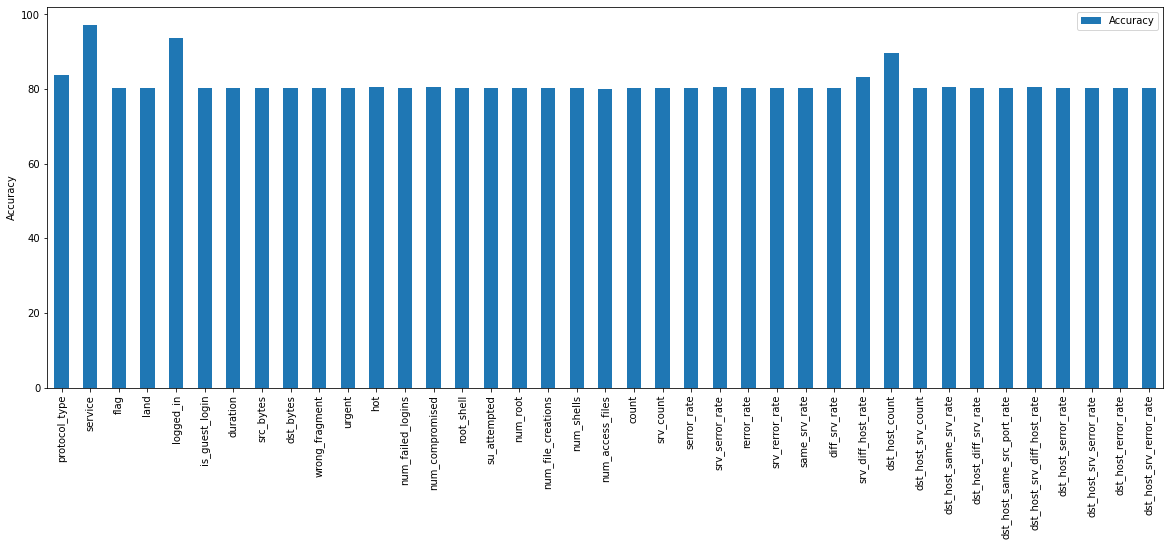

In [97]:
single_column_accuracy_stats_df.plot.bar(figsize=(20,7), ylabel='Accuracy')

In [98]:
single_column_accuracy_stats_df

,Accuracy
protocol_type,83.801264
service,97.111452
flag,80.211329
land,80.369216
logged_in,93.763411
is_guest_login,80.377311
duration,80.275089
src_bytes,80.249786
dst_bytes,80.248773
wrong_fragment,80.327719


### Step - 2 Remove unimportant features and get the accuracy

In [99]:
sorted_single_column_accuracy_stats_df = single_column_accuracy_stats_df.sort_values(by='Accuracy')
sorted_single_column_accuracy_stats_df['feature_name'] = sorted_single_column_accuracy_stats_df.index
sorted_single_column_accuracy_stats_df.reset_index(inplace=True)
sorted_single_column_accuracy_stats_df.drop(columns=['index'], inplace=True)
sorted_single_column_accuracy_stats_df

,Accuracy,feature_name
0,80.106068,num_access_files
1,80.175906,dst_host_diff_srv_rate
2,80.185014,urgent
3,80.190074,srv_rerror_rate
4,80.204242,same_srv_rate
5,80.211329,flag
6,80.230558,serror_rate
7,80.243713,num_file_creations
8,80.248773,dst_bytes
9,80.249786,src_bytes


In [100]:
iterative_feature_removal_stats = {}

for idx, row in sorted_single_column_accuracy_stats_df[:-1].iterrows():
    features_to_remove = sorted_single_column_accuracy_stats_df[:idx+1]['feature_name'].tolist()
    n_features_to_remove = len(features_to_remove)
    
    # remove features from categorical column and continous columns
    new_cat_cols = []
    for cat_col in catg_cols:
        if cat_col not in features_to_remove:
            new_cat_cols.append(cat_col)
    
    new_cont_cols = []
    for cont_col in cont_cols:
        if cont_col not in features_to_remove:
            new_cont_cols.append(cont_col)
    
    new_columns = new_cat_cols + new_cont_cols + ['label']
    model_object, model_selected_history = get_model_accuracy_with_one_or_more_multiple_inputs(df[new_columns],
                                                                                new_columns, new_cont_cols)
    
    
    iterative_feature_removal_stats[f"{n_features_to_remove} removed features"] = model_selected_history.history['val_accuracy'][-1]


(494020, 119)
(494020, 118) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0934 - accuracy: 0.9659 - val_loss: 0.0292 - val_accuracy: 0.9916
Epoch 2/2
1544/1544 [==============================] - 4s 3ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.0240 - val_accuracy: 0.9925


<ipython-input-92-4368d4dfadaa>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[dummy_value_name] = dummy_values[category]


(494020, 118)
(494020, 117) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.1059 - accuracy: 0.9634 - val_loss: 0.0309 - val_accuracy: 0.9914
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0272 - accuracy: 0.9924 - val_loss: 0.0254 - val_accuracy: 0.9930
(494020, 117)
(494020, 116) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.0819 - accuracy: 0.9761 - val_loss: 0.0255 - val_accuracy: 0.9917
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0212 - val_accuracy: 0.9929


C:\Users\PepsiHomeUser\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(494020, 116)
(494020, 115) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.0664 - accuracy: 0.9771 - val_loss: 0.0267 - val_accuracy: 0.9923
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0240 - accuracy: 0.9935 - val_loss: 0.0230 - val_accuracy: 0.9938
(494020, 115)
(494020, 114) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.3325 - accuracy: 0.8230 - val_loss: 0.1279 - val_accuracy: 0.9916
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0803 - accuracy: 0.9923 - val_loss: 0.0473 - val_accuracy: 0.9932
(494020, 104)
(494020, 103) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.1043 - accuracy: 0.9771 - val_loss: 0.0271 - val_accuracy: 0.9921
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0247 - accuracy: 0.9927 - val_loss: 0.0221 - val_accuracy: 0.9939
(494020, 1

(494020, 79)
(494020, 78) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.1473 - accuracy: 0.9557 - val_loss: 0.0467 - val_accuracy: 0.9871
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0423 - accuracy: 0.9878 - val_loss: 0.0398 - val_accuracy: 0.9877
(494020, 78)
(494020, 77) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.1378 - accuracy: 0.9748 - val_loss: 0.0454 - val_accuracy: 0.9873
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.0397 - accuracy: 0.9885 - val_loss: 0.0363 - val_accuracy: 0.9891
(494020, 77)
(494020, 76) (494020,)
98804
Epoch 1/2
1544/1544 [==============================] - 6s 3ms/step - loss: 0.3715 - accuracy: 0.9780 - val_loss: 0.1945 - val_accuracy: 0.9873
Epoch 2/2
1544/1544 [==============================] - 5s 3ms/step - loss: 0.1229 - accuracy: 0.9877 - val_loss: 0.0797 - val_accuracy: 0.9872
(494020, 76)
(49

In [101]:
iterative_feature_removal_stats

{'1 removed features': 0.9925306439399719,
 '2 removed features': 0.9930367469787598,
 '3 removed features': 0.9929254055023193,
 '4 removed features': 0.9938059449195862,
 '5 removed features': 0.9932188987731934,
 '6 removed features': 0.9939172267913818,
 '7 removed features': 0.9923484921455383,
 '8 removed features': 0.9930063486099243,
 '9 removed features': 0.993532657623291,
 '10 removed features': 0.9923181533813477,
 '11 removed features': 0.9930873513221741,
 '12 removed features': 0.9920347332954407,
 '13 removed features': 0.993897020816803,
 '14 removed features': 0.9929254055023193,
 '15 removed features': 0.9931986331939697,
 '16 removed features': 0.992378830909729,
 '17 removed features': 0.9922776222229004,
 '18 removed features': 0.9928545355796814,
 '19 removed features': 0.9925610423088074,
 '20 removed features': 0.9925306439399719,
 '21 removed features': 0.9914780855178833,
 '22 removed features': 0.9910732507705688,
 '23 removed features': 0.9895044565200806,


In [102]:
iterative_feature_removal_stats_df = pd.DataFrame.from_dict(iterative_feature_removal_stats, orient='index', columns=['Accuracy'])

In [103]:
iterative_feature_removal_stats_df['Accuracy'] = iterative_feature_removal_stats_df.apply(lambda row: row['Accuracy'] * 100, axis=1)

<AxesSubplot:ylabel='Accuracy'>

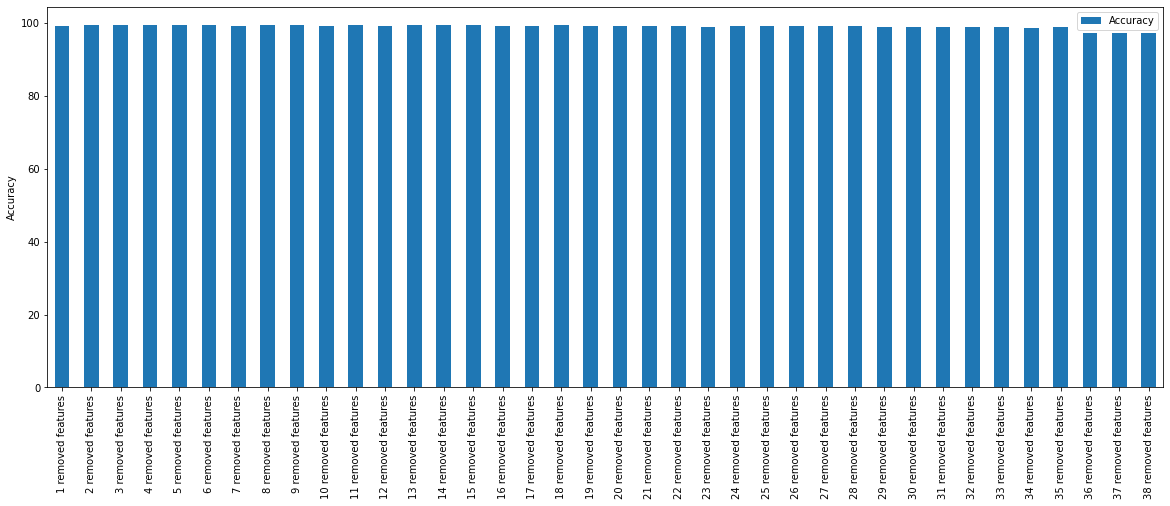

In [104]:
iterative_feature_removal_stats_df.plot.bar(figsize=(20,7), ylabel='Accuracy')

TODO: Zoom y - axis

#### Performance Comparision Plots to do Epoch accuracy graph simialar to phase-3

graph of all features vs graph of best subset features

**Conclusion (TODO):**

The first major drop happened at X time.